In [89]:
import pandas as pd
from datetime import datetime, date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm
import scipy.stats as stats
import plotly.express as px
from mpl_toolkits.basemap import Basemap
from collections import OrderedDict


In [59]:
df1 = pd.read_csv("eda_2018_part1.csv", error_bad_lines=False)
df2 = pd.read_csv("eda_2018_part2.csv", error_bad_lines=False)

/Users/shauryajain/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [60]:
df_merged = df1.append(df2, ignore_index=True)


# Dealing with holidays

In [61]:
df_merged['Date'] = pd.to_datetime(df_merged['Date'])


In [62]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2018-01-01', end='2018-12-31').to_pydatetime()

In [63]:
df_merged["is_holiday"] = df_merged['Date'].isin(holidays)


In [64]:
df_merged[df_merged["is_holiday"] == True]["Departure Delay"].mean(), df_merged[df_merged["is_holiday"] == False]["Departure Delay"].mean()

(10.410245017509602, 9.977159372115064)

In [65]:
# Creating data groups
data_group1 = df_merged[df_merged["is_holiday"] == True]["Departure Delay"]
 
data_group2 = df_merged[df_merged["is_holiday"] == False]["Departure Delay"]
 
# Perform the two sample t-test with equal variances
stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)

Ttest_indResult(statistic=3.9748767394774496, pvalue=7.041645470530936e-05)

# Weather data smoothing

## Before smoothing

In [66]:
df_weather = df_merged[[ 'Departure Delay', 'Origin Temperature Max',
       'Origin Temperature Min', 'Origin Temperature Mean',
       'Origin Apparent Temperature Max', 'Origin Apparent Temperature Min',
       'Origin Apparent Temperature Mean',
       'Origin Shortwave Radiation', 'Origin Precipitation', 'Origin Rain',
       'Origin Snowfall', 'Origin Precipitation Hours', 'Origin Windspeed',
       'Origin Windgusts', 'Origin Wind Direction',
       'Origin Evapotranspiration', 'Destination Weather Code',
       'Destination Temperature Max', 'Destination Temperature Min',
       'Destination Temperature Mean', 'Destination Apparent Temperature Max',
       'Destination Apparent Temperature Min',
       'Destination Apparent Temperature Mean', 'Destination Shortwave Radiation',
       'Destination Precipitation', 'Destination Rain', 'Destination Snowfall',
       'Destination Precipitation Hours', 'Destination Windspeed',
       'Destination Windgusts', 'Destination Wind Direction',
       'Destination Evapotranspiration']]

In [67]:
non_smooth_df_corr = df_weather.corr()

In [68]:
non_smooth_df_corr["Departure Delay"]

Departure Delay                          1.000000
Origin Temperature Max                   0.014213
Origin Temperature Min                   0.026319
Origin Temperature Mean                  0.020214
Origin Apparent Temperature Max          0.027635
Origin Apparent Temperature Min          0.021032
Origin Apparent Temperature Mean         0.024058
Origin Shortwave Radiation              -0.018316
Origin Precipitation                     0.081457
Origin Rain                              0.075562
Origin Snowfall                          0.049973
Origin Precipitation Hours               0.078896
Origin Windspeed                         0.027085
Origin Windgusts                         0.038524
Origin Wind Direction                    0.003348
Origin Evapotranspiration               -0.009206
Destination Weather Code                 0.058544
Destination Temperature Max              0.012636
Destination Temperature Min              0.023038
Destination Temperature Mean             0.017937


## After smoothing

In [69]:
df_smooth_origin = df_merged[['Date','Origin', 'Origin Temperature Max',
       'Origin Temperature Min', 'Origin Temperature Mean',
       'Origin Apparent Temperature Max', 'Origin Apparent Temperature Min',
       'Origin Apparent Temperature Mean',
       'Origin Shortwave Radiation', 'Origin Precipitation', 'Origin Rain',
       'Origin Snowfall', 'Origin Precipitation Hours', 'Origin Windspeed',
       'Origin Windgusts', 'Origin Wind Direction',
       'Origin Evapotranspiration']]

df_smooth_destination = df_merged[['Date', 'Destination',
       'Destination Temperature Max', 'Destination Temperature Min',
       'Destination Temperature Mean', 'Destination Apparent Temperature Max',
       'Destination Apparent Temperature Min',
       'Destination Apparent Temperature Mean', 'Destination Shortwave Radiation',
       'Destination Precipitation', 'Destination Rain', 'Destination Snowfall',
       'Destination Precipitation Hours', 'Destination Windspeed',
       'Destination Windgusts', 'Destination Wind Direction',
       'Destination Evapotranspiration']]

In [70]:
df_smooth_origin = df_smooth_origin.drop_duplicates()
df_smooth_destination = df_smooth_destination.drop_duplicates()

for column in list(df_smooth_origin.iloc[:,2:].columns):
    df_smooth_origin[column] = df_smooth_origin.groupby('Origin')[column].transform(lambda x: x.rolling(window=2).mean())

for column in list(df_smooth_destination.iloc[:,2:].columns):
    df_smooth_destination[column] = df_smooth_destination.groupby('Destination')[column].transform(lambda x: x.rolling(window=2).mean())

df_merged = df_merged[["Date", "Origin", "Destination","Departure Delay"]]
df_merged = pd.merge(df_merged,df_smooth_origin, how="left", on =["Date", "Origin"])
df_merged = pd.merge(df_merged,df_smooth_destination, how="left", on =["Date", "Destination"])
df_merged = df_merged.dropna()

In [74]:
df_smooth_corr = df_merged.iloc[:, 3:].corr()

In [75]:
df_smooth_corr["Departure Delay"]

Departure Delay                          1.000000
Origin Temperature Max                   0.019038
Origin Temperature Min                   0.028934
Origin Temperature Mean                  0.023890
Origin Apparent Temperature Max          0.030877
Origin Apparent Temperature Min          0.025161
Origin Apparent Temperature Mean         0.027913
Origin Shortwave Radiation              -0.011360
Origin Precipitation                     0.075116
Origin Rain                              0.068751
Origin Snowfall                          0.048600
Origin Precipitation Hours               0.071784
Origin Windspeed                         0.018964
Origin Windgusts                         0.028166
Origin Wind Direction                   -0.006689
Origin Evapotranspiration               -0.001496
Destination Temperature Max              0.016563
Destination Temperature Min              0.025024
Destination Temperature Mean             0.020794
Destination Apparent Temperature Max     0.026800


## Comparison before and after smoothing

In [76]:
df_smooth_corrdd = df_smooth_corr["Departure Delay"]
non_smooth_df_corrdd = non_smooth_df_corr["Departure Delay"]
df_smooth_corrdd = pd.DataFrame({'variable':df_smooth_corrdd.index, 'list':df_smooth_corrdd.values})
non_smooth_df_corrdd =pd.DataFrame({'variable':non_smooth_df_corrdd.index, 'list':non_smooth_df_corrdd.values})


In [81]:
df_smooth_corrdd["Phase"] = "After smoothing"
non_smooth_df_corrdd["Phase"] = "Before smoothing"

In [83]:
smoothing_df  = pd.concat([df_smooth_corrdd,non_smooth_df_corrdd], ignore_index=True)

In [86]:
fig = px.histogram(smoothing_df[smoothing_df["variable"].str.contains('Origin')], x="variable", y="list",
             color='Phase', barmode='group',
             height=600, title="Correlation of variables before and after smoothing",labels="correlation")
fig.show()

# Geospacial analysis

In [88]:
airport_data = pd.read_csv("airports.csv")

In [90]:
airport_data = airport_data[airport_data['IATA_CODE'].isin(list(dict.fromkeys(list(df_merged.Origin))))]


In [91]:
count_flights = df_merged['Origin'].value_counts()


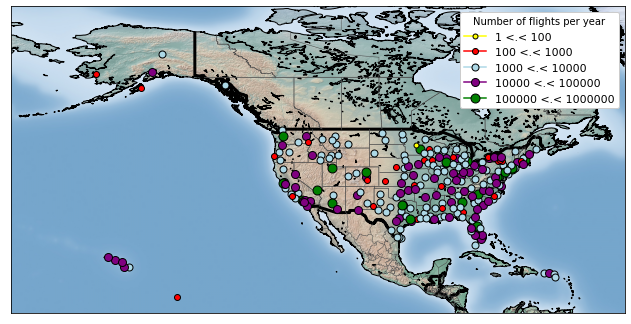

In [94]:
plt.figure(figsize=(11,11))
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
    
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')
for index, (code, y,x) in airport_data[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Number of flights per year', frameon = True, framealpha = 1)
plt.show()

In [104]:
df1 = pd.read_csv("eda_2018_part1.csv", error_bad_lines=False)
df2 = pd.read_csv("eda_2018_part2.csv", error_bad_lines=False)
df_merged = df1.append(df2, ignore_index=True)

/Users/shauryajain/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.



In [105]:
airline_data = pd.read_csv("airlines.csv")
abbr_companies = airline_data.set_index('IATA_CODE')['AIRLINE'].to_dict()
temp = pd.read_csv('airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [106]:
df2 = df_merged[df_merged['Carrier Code'] == "American Airlines"][["Origin","Destination"]]
count_trajectories = df2.groupby(['Origin', 'Destination']).size()


Text(0.5, 1.0, 'Southwest Airlines Co. flights')

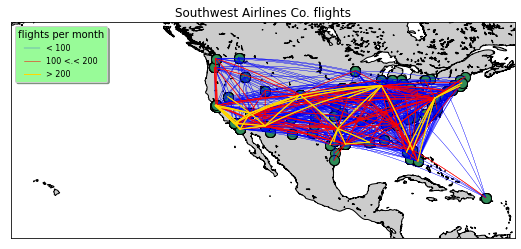

In [108]:
fig=plt.figure(figsize=(7,3))
ax=fig.add_axes([0.,0.,1.,1.])
m = Basemap(resolution='i',llcrnrlon=-165, urcrnrlon=-60,llcrnrlat=10, urcrnrlat=55, lat_0=0, lon_0=0,)
df2 = df_merged[df_merged['Carrier Code'] == "Southwest Airlines"]
count_trajectories = df2.groupby(['Origin', 'Destination']).size()
count_trajectories.sort_values(inplace = True)
    
for (origin, dest), s in count_trajectories.iteritems():
    nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
    m.plot(nylon, nylat, marker='o', markersize = 10, markeredgewidth = 1,
               color = 'seagreen', markeredgecolor='k')

for (origin, dest), s in count_trajectories.iteritems():
    nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
    lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
    if pd.isnull(nylat) or pd.isnull(nylon) or \
            pd.isnull(lonlat) or pd.isnull(lonlon): continue
    if s/12 < 100:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.25, color='b',
                         label = '< 100')
    elif s/12 < 200:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='r',
                         label = '100 <.< 200')
    else:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=1, color='gold',
                          label = '> 200')    
#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('< 100', '100 <.< 200', '> 200')                
new_label = OrderedDict()
for key in key_order:
    if key not in by_label.keys(): continue
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':8},
           title='flights per month', facecolor = 'palegreen', 
           shadow = True, frameon = True, framealpha = 1)    
m.drawcoastlines()
m.fillcontinents()
ax.set_title('{} flights'.format(abbr_companies["WN"]))

Text(0.5, 1.0, 'American Airlines Inc. flights')

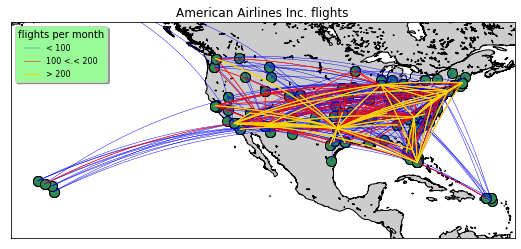

In [110]:
fig=plt.figure(figsize=(7,3))
ax=fig.add_axes([0.,0.,1.,1.])
m = Basemap(resolution='i',llcrnrlon=-165, urcrnrlon=-60,llcrnrlat=10, urcrnrlat=55, lat_0=0, lon_0=0,)
df2 = df_merged[df_merged['Carrier Code'] == "American Airlines"]
count_trajectories = df2.groupby(['Origin', 'Destination']).size()
count_trajectories.sort_values(inplace = True)
    
for (origin, dest), s in count_trajectories.iteritems():
    nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
    m.plot(nylon, nylat, marker='o', markersize = 10, markeredgewidth = 1,
               color = 'seagreen', markeredgecolor='k')

for (origin, dest), s in count_trajectories.iteritems():
    nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
    lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
    if pd.isnull(nylat) or pd.isnull(nylon) or \
            pd.isnull(lonlat) or pd.isnull(lonlon): continue
    if s/12 < 100:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.25, color='b',
                         label = '< 100')
    elif s/12 < 200:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='r',
                         label = '100 <.< 200')
    else:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=1, color='gold',
                          label = '> 200')    
#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('< 100', '100 <.< 200', '> 200')                
new_label = OrderedDict()
for key in key_order:
    if key not in by_label.keys(): continue
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':8},
           title='flights per month', facecolor = 'palegreen', 
           shadow = True, frameon = True, framealpha = 1)    
m.drawcoastlines()
m.fillcontinents()
ax.set_title('{} flights'.format(abbr_companies["AA"]))

Text(0.5, 1.0, 'Delta Air Lines Inc. flights')

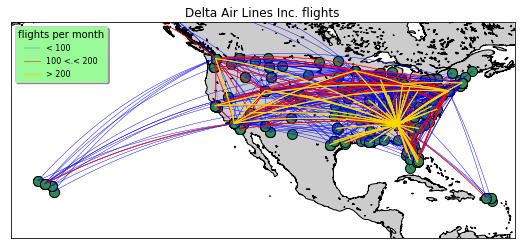

In [111]:
fig=plt.figure(figsize=(7,3))
ax=fig.add_axes([0.,0.,1.,1.])
m = Basemap(resolution='i',llcrnrlon=-165, urcrnrlon=-60,llcrnrlat=10, urcrnrlat=55, lat_0=0, lon_0=0,)
df2 = df_merged[df_merged['Carrier Code'] == "Delta Airlines"]
count_trajectories = df2.groupby(['Origin', 'Destination']).size()
count_trajectories.sort_values(inplace = True)
    
for (origin, dest), s in count_trajectories.iteritems():
    nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
    m.plot(nylon, nylat, marker='o', markersize = 10, markeredgewidth = 1,
               color = 'seagreen', markeredgecolor='k')

for (origin, dest), s in count_trajectories.iteritems():
    nylat,   nylon = latitude_airport[origin], longitude_airport[origin]
    lonlat, lonlon = latitude_airport[dest], longitude_airport[dest]
    if pd.isnull(nylat) or pd.isnull(nylon) or \
            pd.isnull(lonlat) or pd.isnull(lonlon): continue
    if s/12 < 100:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.25, color='b',
                         label = '< 100')
    elif s/12 < 200:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='r',
                         label = '100 <.< 200')
    else:
        m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=1, color='gold',
                          label = '> 200')    
#_____________________________________________
# remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('< 100', '100 <.< 200', '> 200')                
new_label = OrderedDict()
for key in key_order:
    if key not in by_label.keys(): continue
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':8},
           title='flights per month', facecolor = 'palegreen', 
           shadow = True, frameon = True, framealpha = 1)    
m.drawcoastlines()
m.fillcontinents()
ax.set_title('{} flights'.format(abbr_companies["DL"]))